In [1]:
# Package Import Section
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne
import timeit
import astropy.units as u
from scipy.special import erfc
from numba import jit
from numpy.fft import fft
import sys
import poppy

c:\users\jaren\miniconda3\lib\site-packages\pysynphot\locations.py:47: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
c:\users\jaren\miniconda3\lib\site-packages\pysynphot\locations.py:346: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
c:\users\jaren\miniconda3\lib\site-packages\pysynphot\refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for http://ssb.stsci.edu/cdbs_open/cdbs\mtab\*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
c:\users\jaren\miniconda3\lib\site-packages\pysynphot\refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for http://ssb.stsci.edu/cdbs_open/cdbs\mtab\*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [ ]:
# Consider for future use - a raygrid class separated from the Rayfront class so that GBD also supports run-of-the-mill raytracing
# Aberration calculations? Can't do with ABCD matrices, but snell's law interactions could be interesting

class GaubletWavefront():
    
    def __init__(self,
                 wavelength,
                 size,
                 samplescheme):
        
        self.wavelength = wavelength
        self.size = size
        self.samplescheme = samplescheme
        
        self.OF = 1.7
        self.wo = 100*self.wavelength
        zr = np.pi*self.wo**2.0/self.wavelength
        
        self.Q = np.array([[1.0/(1j*zr),0],
                           [0,1.0/(1j*zr)]],dtype='complex')
        
        if self.samplescheme == 'fibbonacci':
            
            self.numrays = np.int(np.round(np.pi*((self.size/2.0)*self.OF/(self.wo))*9.0)) # This is arbitrary scaling
            print('numbeamlets across grid = ',self.numrays)
                
            
            c = np.array([0,0]) # XY offset from a spiral
            R = (self.size/2)*np.sqrt(np.linspace(1/2,self.numrays-1/2,self.numrays))/np.sqrt(self.numrays-1/2)
            T = 4/(1+np.sqrt(5))*np.pi*np.linspace(1,self.numrays,self.numrays);
            X = c[0] +R*np.cos(T)
            Y = c[1] +R*np.sin(T)
            
        elif self.samplescheme == 'even':
            
            self.numrays = np.int(np.round(self.size*self.OF/(2*self.wo)))
            print('numbeamlets across grid = ',self.numrays)
            
            # Define lists of XY coordinate pairs for square grid
            x = np.linspace(-self.size/2,self.size/2,self.numrays)
            y = np.linspace(-self.size/2,self.size/2,self.numrays)
            x,y = np.meshgrid(x,y)
            X = np.concatenate(x).flatten('F')
            Y = np.concatenate(y).flatten('F')
            self.numrays = self.numrays**2
            print('total numbeamlets = ',self.numrays)
            
        self.rays = np.array([X,
                              Y,
                              0*X,
                              0*Y,
                              0*X+1])  # define grid of rays paralell to propagation
        
        self.baserays = self.rays # store original ray positions
            
        
    def propogate(self,elements):
        
        Gconf = 1 # the radius of pixels to search for a zero value in the aperture plane
        sys = elements[0]['data']
        
        for eind in range(len(elements)):
            
            if eind != 0:
                
                staged_element = elements[eind]
                
                
                # Considers Optics, Distances
                if staged_element['type'] == 'matrix':
                    
                    sys = np.matmul(staged_element['data'],sys)
                    
                # Considers Apertures & Vignetting
                elif staged_element['label'] == 'aperture':
                    
                    print('Vignetting Rays')
                    
                    self.rays = np.matmul(sys,self.baserays)
                    extent = staged_element['extent']
                    ind2del = [] # predefine list of indices to delete
                    
                    for rind in range(self.numrays):
                        
                        staged_ray = self.rays[:,rind]
                        rx_coord = staged_ray[0]
                        ry_coord = staged_ray[1]
                        
                        idx = np.abs(extent-rx_coord).argmin() # fix plsss
                        idy = np.abs(extent-ry_coord).argmin()
                        
                        # PRESENTLY ONLY STOPS IF IT VIGNETTES THE CENTER RAY - THIS IS NOT OPTIMAL
                        if staged_element['data'][idx,idy] == 0:
                            
                            ind2del.append(rind)
                            
                    self.rays = np.delete(self.rays,ind2del,axis=1)
                    self.baserays = np.delete(self.baserays,ind2del,axis=1)
                    self.numrays = len(self.rays[0])
                    print('Remaining Rays = ',self.numrays)
                
                # Considers The Detector plane
                elif staged_element['label'] == 'detector':
                    
                    # This method assumes that all apertures have been added previously
                    self.rays = np.matmul(sys,self.baserays)
                    
                    print('Evaluating Rayfront')
                    
                    # Optical system sub-matrices
                    A = sys[0:2,0:2] # this has a tendency to be zero-valued at focus
                    B = sys[0:2,2:4]
                    C = sys[2:4,0:2]
                    D = sys[2:4,2:4]
                    
                    # Propagate the Q matrix - Complex Curvature
                    Qprop_n = (C + np.matmul(D,self.Q))
                    Qprop_d = np.linalg.inv(A+np.matmul(B,self.Q))
                    Qprop   = np.matmul(Qprop_n,Qprop_d)
                    
                    # Propagate the P matrix - Complex Shear
                    #Pprop   = np.matmul(np.linalg.inv(np.matmul(C,np.linalg.inv(self.Q))+D),self.baserays[0:2])
                    
                    #if np.linalg.det(A) == 0:
                        #orig_matrix = np.zeros([2,2])   
                    #else:
                    orig_matrix = np.linalg.inv(np.linalg.inv(self.Q) + np.matmul(np.linalg.inv(A),B))
                    
                    cros_matrix = np.linalg.inv(np.matmul(A,np.linalg.inv(self.Q))+B)
                    
                    u = staged_element['xarray']
                    v = staged_element['yarray']
                    
                    Dphase = np.zeros([len(u[0,:]),len(u[0,:]),self.numrays],dtype='complex')
                    
                    phase = self.PhaseCube(self.wavelength,
                                           sys,
                                           Qprop,
                                           self.baserays,
                                           self.rays,
                                           self.numrays,
                                           orig_matrix,
                                           cros_matrix,
                                           u,
                                           v,
                                           Dphase)
                    
                    phasor = ne.evaluate('exp(phase)')
                    self.Ephase = np.sum(phasor,axis=2)*np.sqrt(np.linalg.det(A+np.matmul(B,self.Q)))
    
    @staticmethod
    @jit(nopython=True,parallel=True)
    def PhaseCube(wavelength,
                  sys,
                  Qprop,
                  baserays,
                  proprays,
                  numrays,
                  orig_matrx,
                  cros_matrx,
                  udimspace,
                  vdimspace,
                  Dphase):
        
        npix = len(udimspace[0,:])
        A = sys[0:2,0:2]
        B = sys[0:2,2:4]
        C = sys[2:4,0:2]
        D = sys[2:4,2:4]
        lo = sys[0,2] # THIS ASSUMES AN ORTHOGONAL OPTICAL SYSTEM
        
        for rayind in np.arange(0,numrays):
            
            uo = udimspace-baserays[0,rayind]
            vo = vdimspace-baserays[1,rayind]
            
            up = udimspace-proprays[0,rayind]
            vp = vdimspace-proprays[1,rayind]
            
            # And this is where all the math comes in (Lin et al)
            guoy_phase = -1j*np.arctan(lo/np.real(Qprop[0,0]))
            tran_phase = (-1j*(np.pi/wavelength))*(Qprop[0,0]*up**2 + (Qprop[1,0] + Qprop[0,1])*up*vp + Qprop[1,1]*vp**2)
            long_phase = -1j*(2.0*np.pi/wavelength)*lo

            orig_phase = (-1j*(np.pi/wavelength))*(orig_matrx[0,0]*uo**2 + (orig_matrx[1,0] + orig_matrx[0,1])*uo*vo + orig_matrx[1,1]*vo**2)

            cros_phase = (-1j*(2*np.pi/wavelength))*( cros_matrx[0,0]*uo*up + (cros_matrx[1,0] + cros_matrx[0,1])*uo*vp + cros_matrx[1,1]*vo*vp )
            Dphase[:,:,rayind] = tran_phase+long_phase+guoy_phase+orig_phase+cros_phase
            
        return Dphase
        
                        

    

In [ ]:
class GaubletOpticalSystem():
    
    def __init__(self,
                 dimd,
                 npix):
        
        self.dimd = dimd # the detector side dimension
        self.npix = npix # the number of pixels on the detector
        
        self.eyea = np.array([[1.0,0,0,0,0],
                              [0,1.0,0,0,0],
                              [0,0,1.0,0,0],
                              [0,0,0,1.0,0],
                              [0,0,0,0,1.0]]) # Identity Matrix Optical System
        
        self.syst = self.eyea
        first_element = {'label':'wavefront',
                        'type':'matrix',
                        'data':self.eyea}
        
        self.elements = [first_element]
        
    
    def add_optic(self,eflx,efly,dx,dy,tx,ty):
        
        # Focusing matrix
        optic = np.array([[1.0,0.0,0.0,0.0,dx],
                          [0.0,1.0,0.0,0.0,dy],
                          [-1.0/float(eflx),0.0,1.0,0.0,tx],
                          [0.0,-1.0/float(efly),0.0,1.0,ty],
                          [0.0,0.0,0.0,0.0,1]])
        
        self.elements.append({'label':'optic',
                              'type':'matrix',
                              'data':optic})
        
    def add_distance(self,distance,index,dx,dy,tx,ty):
        
        # Propagation matrix
        distance = np.array([[1.0,0.0,float(distance)/float(index),0.0,dx],
                             [0.0,1.0,0.0,float(distance)/float(index),dy],
                             [0.0,0.0,1.0,0.0,tx],
                             [0.0,0.0,0.0,1.0,ty],
                             [0.0,0.0,0.0,0.0,1]])
        
        self.elements.append({'label':'distance',
                              'type':'matrix',
                              'data':distance})
        
    def add_aperture(self,shape,diameter):
        
        if shape == 'lyot':
            
            scaledpix = self.npix
            print('scaledpix',scaledpix)
            
            ap = np.zeros([scaledpix,scaledpix])
            u = np.linspace(-diameter/2,diameter/2,scaledpix)
            v = np.linspace(-diameter/2,diameter/2,scaledpix)
                        
            for xind in range(scaledpix):
                for yind in range(scaledpix):
                    
                    if np.sqrt(u[xind]**2 + v[yind]**2) <= diameter/2:
                        
                        ap[xind,yind] = 1
            
        if shape == 'fpm':
            
            scaledpix = int(round(self.npix*(diameter/self.dimd)))
            
            ap = np.zeros([scaledpix,scaledpix])
            u = np.linspace(-diameter/2,diameter/2,scaledpix)
            v = np.linspace(-diameter/2,diameter/2,scaledpix)
                        
            for xind in range(scaledpix):
                for yind in range(scaledpix):
                    
                    if np.sqrt(u[xind]**2 + v[yind]**2) >= diameter/2:
                        
                        ap[xind,yind] = 1
            
        self.elements.append({'label':'aperture',
                              'type':'array',
                              'extent':u,
                              'data':ap})
        if shape == 'keck':
            
            ap = 1
        
    def add_detector(self):
        
        u = np.linspace(-self.dimd/2,self.dimd/2,self.npix)
        v = u
        u,v = np.meshgrid(u,v)
        
        self.elements.append({'label':'detector',
                              'type':'array',
                              'xarray':u,
                              'yarray':v})
                        
        
    
        
        

In [ ]:
gwfr = GaubletWavefront(wavelength=2.2e-6,size=25.4e-3,samplescheme='fibbonacci')
osys = GaubletOpticalSystem(dimd=25.4,npix=512)
for Lind in range(1,5):
    osys.add_optic(eflx=100e-3,efly=100e-3,dx=0,dy=0,tx=0,ty=0)
    osys.add_distance(distance=200e-3,index=1,dx=0,dy=0,tx=0,ty=0)


osys.add_optic(eflx=5.52,efly=5.52,dx=0,dy=0,tx=0,ty=0)          # defocus
osys.add_distance(distance=(1.2**2)/(2.2e-6 *5),index=1,dx=0,dy=0,tx=0,ty=0) # fresnel number of 3 = .00947
#osys.add_distance(distance=5e-2,index=1)
#osys.add_optic(efl=2.5e-2)
#osys.add_distance(distance=5e-2,index=1)
osys.add_detector()
gwfr.propogate(elements=osys.elements)

# 15k is too much
# 14k is ok
# Lyot stop needs to be shifted on-axis
# it's the same index responsible for both lists (y >= 0, x >= 0)

In [ ]:
img = (np.abs(gwfr.Ephase*np.conj(gwfr.Ephase)))
plt.figure(figsize=[10,10])
plt.imshow(img,extent=[-1.2,1.2,-1.2,1.2],interpolation='none')
plt.show()

In [ ]:
np.savetxt('2.4_0.5_NF5_Poisson_25056B_1500wo.txt',img,delimiter=',')

In [10]:
# exponential testing
import os
from numba import jit
import numexpr as ne
import timeit
import numpy as np
phase = np.ones([512,512,1024],dtype='complex128')
os.environ['NUMEXPR_MAX_THREADS'] = '1000'
os.environ['NUMEXPR_NUM_THREADS'] = '1000'

In [11]:
%%timeit
phasorne = ne.evaluate('exp(phase)')

9.61 s ± 376 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit

@jit(nopython=True,parallel=True)
def numbaexp(phase):
    phasor = np.exp(phase)
    
    return phasor

phasornu = numbaexp(phase)
    

11.5 s ± 305 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(<matplotlib.axes._subplots.AxesSubplot at 0x174849d0908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17484a0c5c8>)

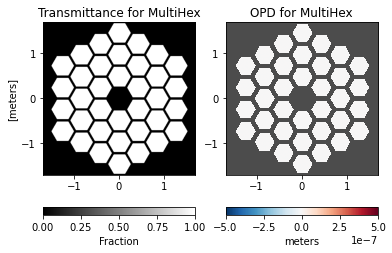

In [9]:
# Get Poppy Segment Aperture (Keck-like PSF)
optic = poppy.MultiHexagonAperture(side=0.25, rings=3, gap=0.05, center=False)
optic.display(what='both')